In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from lifelines import KaplanMeierFitter

In [3]:
# !pip install lifelines

In [4]:
cancer_data = pd.read_excel("./cancer_patient_data.xlsx")

In [5]:
cancer_data.tail()

,BIRTH_DATE_off,DEATH_DATE_off,sex,race,LUNG,PANCREAS,THYROID,COLORECTAL,MELANOMA,LUNG DT,PANCREAS_DT,THYROID_DT,COLORECTAL_DT,MELANOMA_DT
8463,1948-11-28,NaT,Male,More than one Race,0,0,1,0,0,NaT,NaT,2015-02-06,NaT,NaT
8464,1938-07-05,NaT,Female,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8465,1958-06-05,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT
8466,1955-12-29,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,2013-01-06
8467,1967-04-09,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,2012-09-10


# Preprocessing

In [6]:
cancer_data.dtypes

BIRTH_DATE_off    datetime64[ns]
DEATH_DATE_off    datetime64[ns]
sex                       object
race                      object
LUNG                       int64
PANCREAS                   int64
THYROID                    int64
COLORECTAL                 int64
MELANOMA                   int64
LUNG DT           datetime64[ns]
PANCREAS_DT       datetime64[ns]
THYROID_DT        datetime64[ns]
COLORECTAL_DT     datetime64[ns]
MELANOMA_DT       datetime64[ns]
dtype: object

In [7]:
# Dictionary mapping current column names to desired names
column_mapping = {
    'BIRTH_DATE_off': 'birth_date_off',
    'DEATH_DATE_off': 'death_date_off',
    'LUNG': 'lung',
    'PANCREAS': 'pancreas',
    'THYROID': 'thyroid',
    'COLORECTAL': 'colorectal',
    'MELANOMA': 'melanoma',
    'LUNG DT': 'lung_dt',
    'PANCREAS_DT': 'pancreas_dt',
    'THYROID_DT': 'thyroid_dt',
    'COLORECTAL_DT': 'colorectal_dt',
    'MELANOMA_DT': 'melanoma_dt'
}

# Rename the columns
cancer_data = cancer_data.rename(columns=column_mapping)

# Display the renamed columns
print(cancer_data.columns)


Index(['birth_date_off', 'death_date_off', 'sex', 'race', 'lung', 'pancreas',
       'thyroid', 'colorectal', 'melanoma', 'lung_dt', 'pancreas_dt',
       'thyroid_dt', 'colorectal_dt', 'melanoma_dt'],
      dtype='object')


In [8]:
cancer_data.head(3)

,birth_date_off,death_date_off,sex,race,lung,pancreas,thyroid,colorectal,melanoma,lung_dt,pancreas_dt,thyroid_dt,colorectal_dt,melanoma_dt
0,1959-12-02,NaT,Male,Black/African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT
1,1955-11-18,2016-04-20,Male,Black/African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT
2,1946-01-14,2015-05-25,Female,Black/African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT


In [9]:
cancer_data.shape

(8468, 14)

## Task 1 - Calculate age of each patient at the time of cancer diagnosis

In [10]:
for col in cancer_data.columns:
    if "_dt" in col:
        cancer_data[col.replace('_dt', '_AgeAtDiagnosis')] = (
            cancer_data[col] - cancer_data['birth_date_off']
        ) / pd.Timedelta(days=365.25)

        cancer_data[col.replace('_dt', '_AgeAtDiagnosis')] = cancer_data[col.replace('_dt', '_AgeAtDiagnosis')].apply(lambda x: round(x) if pd.notnull(x) else x)

        

In [11]:
cancer_data.tail()

,birth_date_off,death_date_off,sex,race,lung,pancreas,thyroid,colorectal,melanoma,lung_dt,pancreas_dt,thyroid_dt,colorectal_dt,melanoma_dt,lung_AgeAtDiagnosis,pancreas_AgeAtDiagnosis,thyroid_AgeAtDiagnosis,colorectal_AgeAtDiagnosis,melanoma_AgeAtDiagnosis
8463,1948-11-28,NaT,Male,More than one Race,0,0,1,0,0,NaT,NaT,2015-02-06,NaT,NaT,NaN,NaN,66.0,NaN,NaN
8464,1938-07-05,NaT,Female,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN
8465,1958-06-05,NaT,Female,Black/African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN
8466,1955-12-29,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,2013-01-06,NaN,NaN,NaN,NaN,57.0
8467,1967-04-09,NaT,Female,White,0,0,0,0,1,NaT,NaT,NaT,NaT,2012-09-10,NaN,NaN,NaN,NaN,45.0


## Task 2 - Remove diagnoses after 8/25/2016

In [12]:
end_date = pd.Timestamp('2016-08-25')

In [13]:
# Convert all date columns to datetime

cancer_data['birth_date_off'] = pd.to_datetime(cancer_data['birth_date_off'])
cancer_data['death_date_off'] = pd.to_datetime(cancer_data['death_date_off'])

cancer_data['lung_dt'] = pd.to_datetime(cancer_data['lung_dt'])
cancer_data['pancreas_dt'] = pd.to_datetime(cancer_data['pancreas_dt'])
cancer_data['thyroid_dt'] = pd.to_datetime(cancer_data['thyroid_dt'])
cancer_data['colorectal_dt'] = pd.to_datetime(cancer_data['colorectal_dt'])
cancer_data['melanoma_dt'] = pd.to_datetime(cancer_data['melanoma_dt'])

In [14]:
# Check if the death_date_off is NaT or after the end_date, then censor

cancer_data['censored'] = cancer_data['death_date_off'].isna() | (cancer_data['death_date_off'] > end_date)

## Task 3 - Categorize race

In [15]:
unique_races = cancer_data['race'].unique()
print(unique_races)

['Black/African-American' 'White' 'Unknown' 'Asian/Mideast Indian'
 'Patient Declined' 'Native Hawaiian/Other Pacific Islander'
 'American Indian or Alaska Native' 'More than one Race' nan]


In [16]:
race_mapping = {
    'White': 'White',
    'Black/African-American': 'African-American',
    'Asian/Mideast Indian': 'Asian/Mideast-Indian'
    # Add any other specific race names you have in your data to map them correctly
}
cancer_data['race'] = cancer_data['race'].map(race_mapping).fillna('Others')

In [17]:
cancer_data.head()

,birth_date_off,death_date_off,sex,race,lung,pancreas,thyroid,colorectal,melanoma,lung_dt,pancreas_dt,thyroid_dt,colorectal_dt,melanoma_dt,lung_AgeAtDiagnosis,pancreas_AgeAtDiagnosis,thyroid_AgeAtDiagnosis,colorectal_AgeAtDiagnosis,melanoma_AgeAtDiagnosis,censored
0,1959-12-02,NaT,Male,African-American,1,0,0,0,0,2013-09-01,NaT,NaT,NaT,NaT,54.0,NaN,NaN,NaN,NaN,True
1,1955-11-18,2016-04-20,Male,African-American,1,0,0,0,0,2016-04-02,NaT,NaT,NaT,NaT,60.0,NaN,NaN,NaN,NaN,False
2,1946-01-14,2015-05-25,Female,African-American,1,0,0,0,0,2015-04-11,NaT,NaT,NaT,NaT,69.0,NaN,NaN,NaN,NaN,False
3,1932-07-28,NaT,Female,African-American,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,True
4,1943-04-17,NaT,Male,White,0,0,0,0,0,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,True


In [18]:
# # Check the distribution of the 'Censored' column
print(cancer_data['censored'].value_counts())

True     8068
False     400
Name: censored, dtype: int64


In [19]:
# cancer_types = ['lung_dt', 'pancreas_dt', 'thyroid_dt', 'colorectal_dt', 'melanoma_dt']

# for cancer_type in cancer_types:
#     cancer_data[cancer_type] = pd.to_datetime(cancer_data[cancer_type])  # Ensure the column is in datetime format
    
#     # Replace with NaT where the condition is met
#     cancer_data[cancer_type] = cancer_data[cancer_type].where(cancer_data[cancer_type] <= end_date, pd.NaT)


In [20]:
cancer_data = cancer_data.drop(['lung',
                                'pancreas',
                                'thyroid',
                                'colorectal',
                                'melanoma',
                                'birth_date_off',
                                ], axis=1)

cancer_data.head()

,death_date_off,sex,race,lung_dt,pancreas_dt,thyroid_dt,colorectal_dt,melanoma_dt,lung_AgeAtDiagnosis,pancreas_AgeAtDiagnosis,thyroid_AgeAtDiagnosis,colorectal_AgeAtDiagnosis,melanoma_AgeAtDiagnosis,censored
0,NaT,Male,African-American,2013-09-01,NaT,NaT,NaT,NaT,54.0,NaN,NaN,NaN,NaN,True
1,2016-04-20,Male,African-American,2016-04-02,NaT,NaT,NaT,NaT,60.0,NaN,NaN,NaN,NaN,False
2,2015-05-25,Female,African-American,2015-04-11,NaT,NaT,NaT,NaT,69.0,NaN,NaN,NaN,NaN,False
3,NaT,Female,African-American,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,True
4,NaT,Male,White,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,True


In [21]:
cancer_data.isnull().sum()

death_date_off               8021
sex                             0
race                            0
lung_dt                      6983
pancreas_dt                  7808
thyroid_dt                   7723
colorectal_dt                7522
melanoma_dt                  8122
lung_AgeAtDiagnosis          6983
pancreas_AgeAtDiagnosis      7808
thyroid_AgeAtDiagnosis       7723
colorectal_AgeAtDiagnosis    7522
melanoma_AgeAtDiagnosis      8122
censored                        0
dtype: int64

In [22]:
# QUESTION - 2

# Step 1: Create a list of columns that contain diagnosis dates for different cancers.
cancer_types = ['lung_dt', 'pancreas_dt', 'thyroid_dt', 'colorectal_dt', 'melanoma_dt']

# Step 2: Sum up the number of non-null diagnosis dates for each patient.
# This gives you the total number of cancer diagnoses for each patient.
cancer_data['num_diagnoses'] = cancer_data[cancer_types].notnull().sum(axis=1)

# Step 3: Count the number of patients with exactly two diagnoses.
num_patients_with_two_diagnoses = (cancer_data['num_diagnoses'] == 2).sum()

print(f"Number of patients with two cancer diagnoses: {num_patients_with_two_diagnoses}")


Number of patients with two cancer diagnoses: 29


# Data Processing

In [23]:
# Your diagnosis columns and the corresponding age at diagnosis columns
cancer_types = ['lung_dt', 'pancreas_dt', 'thyroid_dt', 'colorectal_dt', 'melanoma_dt']
age_at_diagnosis_columns = ['lung_AgeAtDiagnosis', 'pancreas_AgeAtDiagnosis', 'thyroid_AgeAtDiagnosis', 'colorectal_AgeAtDiagnosis', 'melanoma_AgeAtDiagnosis']

# A hypothetical date for the end of study, for censoring
end_of_study = pd.to_datetime('2016-08-25')

# Create a new dataframe to store processed data
processed_data = []

for cancer_type, age_col in zip(cancer_types, age_at_diagnosis_columns):
    # Extract relevant columns
    temp_data = cancer_data[['death_date_off', 'sex', 'race', cancer_type, age_col, 'censored']].copy()
    
    # Rename the columns for consistency
    temp_data.rename(columns={cancer_type: 'diagnosis_date', age_col: 'age_at_diagnosis'}, inplace=True)
    
    # Calculate the duration from diagnosis to end of study or death
    # For patients still alive or lost to follow-up at the end of the study, use the end_of_study as the end point
    temp_data['duration'] = (temp_data['death_date_off'].fillna(end_of_study) - temp_data['diagnosis_date']).dt.days

    # Determine if the event was observed or censored
    # An event is observed if death_date_off is not NaN and before the end of the study
    # Otherwise, it's censored
    temp_data['event_observed'] = ~temp_data['death_date_off'].isna() & (temp_data['death_date_off'] <= end_of_study)
    
    # For patients who do not have a diagnosis date, we keep them only if death_date_off is available
    # and they are censored
    temp_data = temp_data.dropna(subset=['diagnosis_date', 'age_at_diagnosis'], how='all')
    
    # Assign the type of cancer to a new column
    temp_data['cancer_type'] = cancer_type.replace('_dt', '')
    
    # Append to the list
    processed_data.append(temp_data)

# Concatenate all the temporary dataframes
final_data = pd.concat(processed_data, ignore_index=True)

# Now you have a dataframe where each row is an instance of a patient's cancer, with censored status and duration included


In [24]:
final_data

,death_date_off,sex,race,diagnosis_date,age_at_diagnosis,censored,duration,event_observed,cancer_type
0,NaT,Male,African-American,2013-09-01,54.0,True,1089.0,False,lung
1,2016-04-20,Male,African-American,2016-04-02,60.0,False,18.0,True,lung
2,2015-05-25,Female,African-American,2015-04-11,69.0,False,44.0,True,lung
3,NaT,Male,African-American,2012-11-29,55.0,True,1365.0,False,lung
4,NaT,Male,African-American,2013-05-21,73.0,True,1192.0,False,lung
...,...,...,...,...,...,...,...,...,...
4177,NaT,Female,White,2010-08-01,46.0,True,2216.0,False,melanoma
4178,NaT,Female,White,2015-10-25,35.0,True,305.0,False,melanoma
4179,NaT,Male,White,2013-11-09,64.0,True,1020.0,False,melanoma
4180,NaT,Female,White,2013-01-06,57.0,True,1327.0,False,melanoma


In [25]:
final_data.isnull().sum()

death_date_off      3852
sex                    0
race                   0
diagnosis_date         0
age_at_diagnosis       0
censored               0
duration               0
event_observed         0
cancer_type            0
dtype: int64

In [26]:
final_data.shape

(4182, 9)

In [27]:
final_data.dtypes

death_date_off      datetime64[ns]
sex                         object
race                        object
diagnosis_date      datetime64[ns]
age_at_diagnosis           float64
censored                      bool
duration                   float64
event_observed                bool
cancer_type                 object
dtype: object

# EDA

## Distribution of ages at diagnosis for each type of cancer

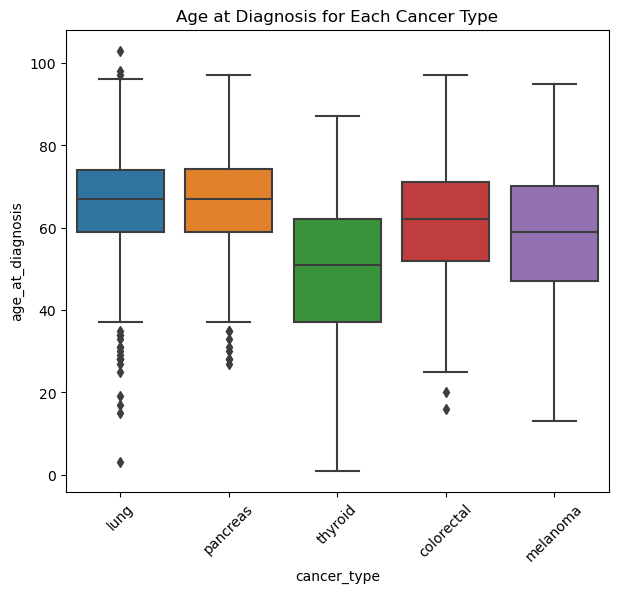

In [28]:

final_data['age_at_diagnosis'] = pd.to_numeric(final_data['age_at_diagnosis'], errors='coerce')

plt.figure(figsize=(7, 6))
sns.boxplot(data=final_data, x='cancer_type', y='age_at_diagnosis')
plt.xticks(rotation=45)  # Rotate the cancer type labels for better readability
plt.title('Age at Diagnosis for Each Cancer Type')
plt.show()

## Censoring Data Distribution

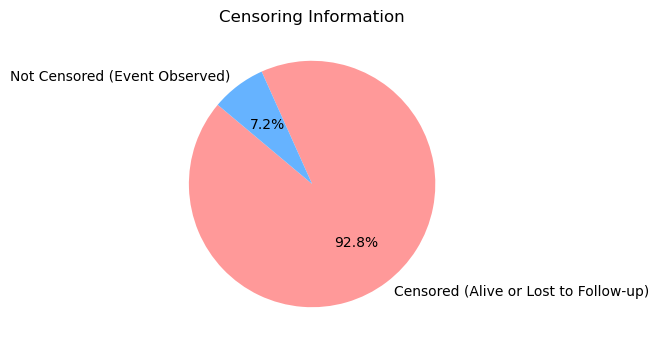

In [29]:
# Assuming 'censored' column is boolean or contains two unique categorical values for censored data
censor_counts = final_data['censored'].value_counts()

# Define labels for the pie chart.
labels = ['Censored (Alive or Lost to Follow-up)', 'Not Censored (Event Observed)']

# Choose colors for each section of the pie.
colors = ['#ff9999','#66b3ff']

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(censor_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Censoring Information')
plt.show()

In [30]:
final_data

,death_date_off,sex,race,diagnosis_date,age_at_diagnosis,censored,duration,event_observed,cancer_type
0,NaT,Male,African-American,2013-09-01,54.0,True,1089.0,False,lung
1,2016-04-20,Male,African-American,2016-04-02,60.0,False,18.0,True,lung
2,2015-05-25,Female,African-American,2015-04-11,69.0,False,44.0,True,lung
3,NaT,Male,African-American,2012-11-29,55.0,True,1365.0,False,lung
4,NaT,Male,African-American,2013-05-21,73.0,True,1192.0,False,lung
...,...,...,...,...,...,...,...,...,...
4177,NaT,Female,White,2010-08-01,46.0,True,2216.0,False,melanoma
4178,NaT,Female,White,2015-10-25,35.0,True,305.0,False,melanoma
4179,NaT,Male,White,2013-11-09,64.0,True,1020.0,False,melanoma
4180,NaT,Female,White,2013-01-06,57.0,True,1327.0,False,melanoma


# Model

In [5]:
# Initialize a KaplanMeierFitter instance
kmf = KaplanMeierFitter()

# List of cancers to analyze
cancers = ['lung', 'pancreas', 'thyroid', 'colorectal', 'melanoma']


## Survival Analysis by GENDER

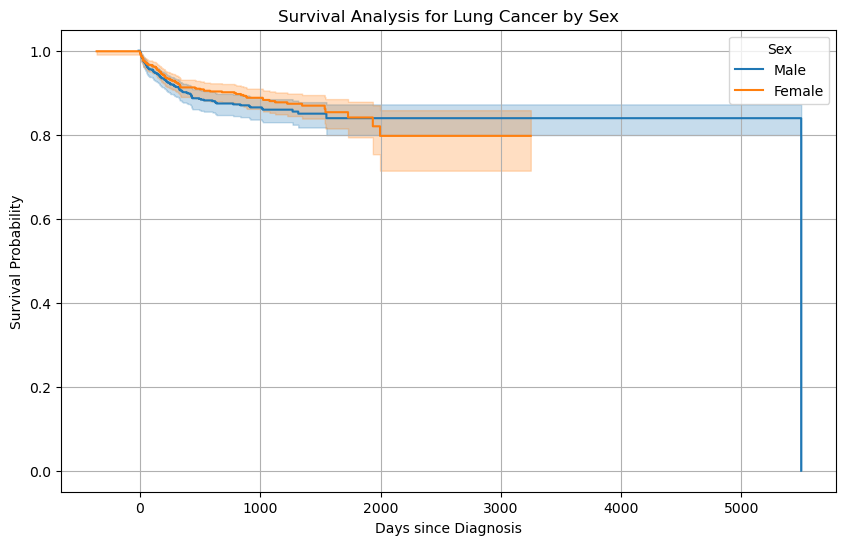

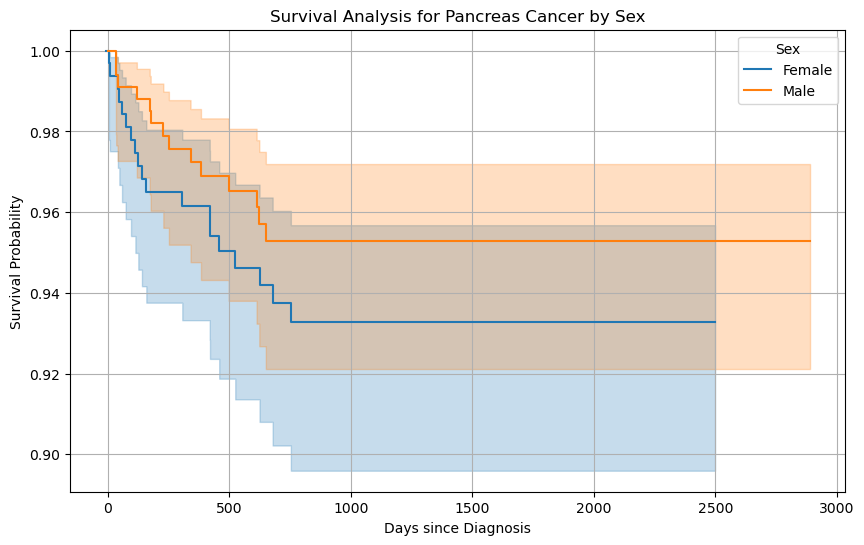

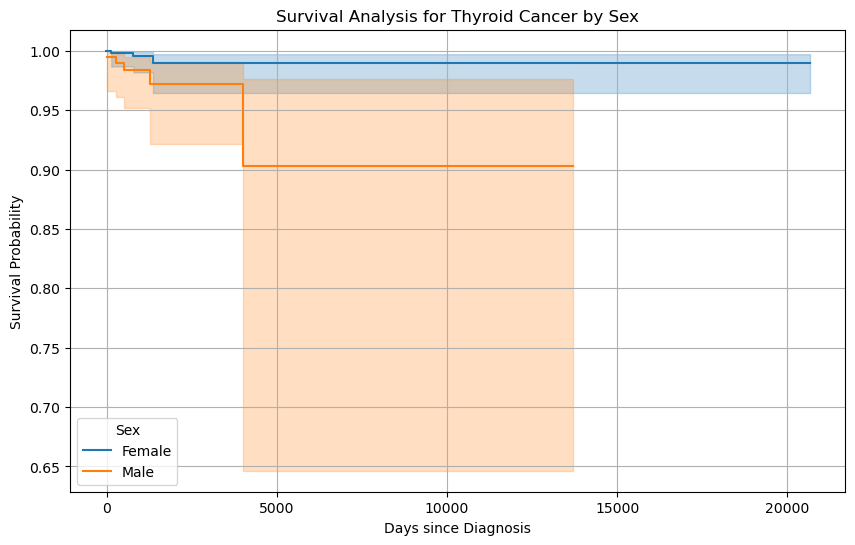

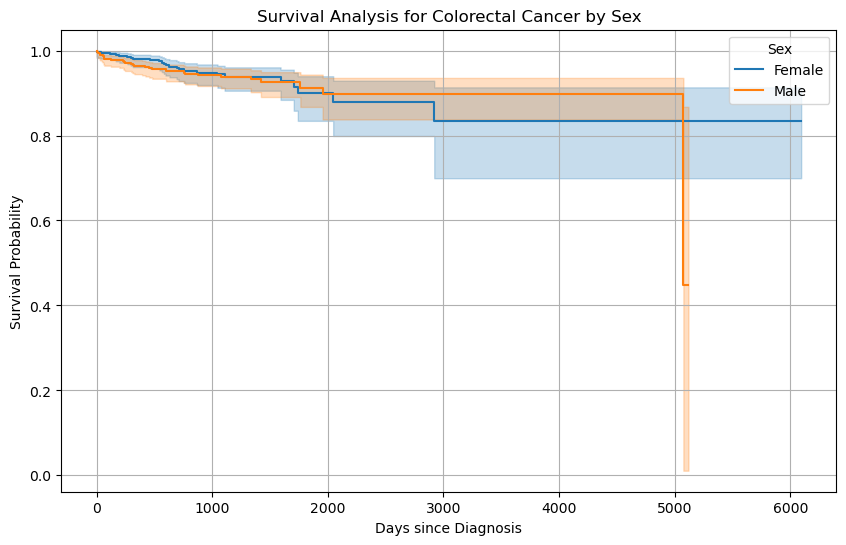

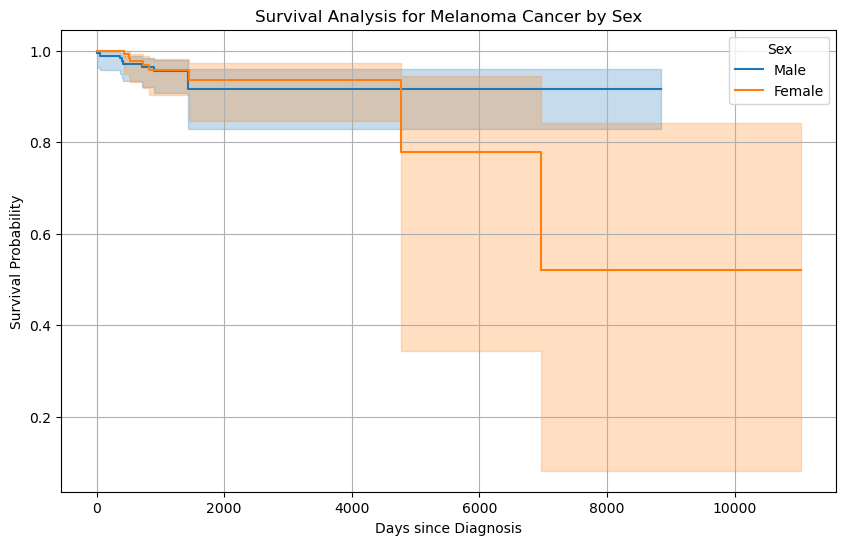

In [32]:
for cancer in cancers:
    # Filter data for the specific cancer type
    data_cancer = final_data[final_data['cancer_type'] == cancer]
    
    # Get unique sexes in the dataset
    sexes = data_cancer['sex'].unique()
    
    # Create a new figure for the cancer type
    plt.figure(figsize=(10, 6))
    
    # Loop over each sex
    for sex in sexes:
        # Filter data for the specific sex
        data_sex = data_cancer[data_cancer['sex'] == sex]
        
        # Check if there is enough data to plot
        if data_sex.empty:
            continue
        
        # Fit the Kaplan-Meier model for the specific cancer type and sex
        kmf.fit(durations=data_sex['duration'],
                event_observed=data_sex['event_observed'],
                label=f'{sex}')
        
        # Plot the survival function
        kmf.plot_survival_function()

          # Add title and labels
    plt.title(f'Survival Analysis for {cancer.capitalize()} Cancer by Sex')
    plt.xlabel('Days since Diagnosis')
    plt.ylabel('Survival Probability')
    plt.legend(title='Sex')
    plt.grid(True)
        
    # Show plot
    plt.show()

## Survival Analysis by RACE

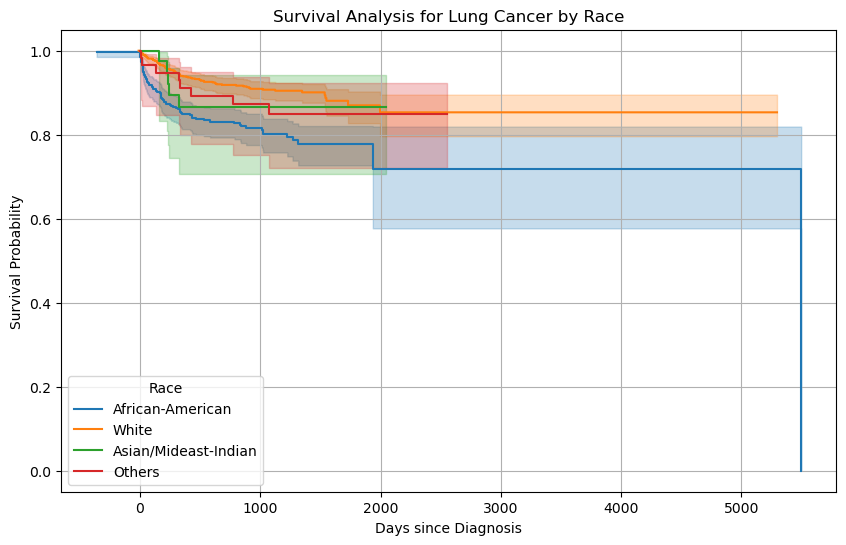

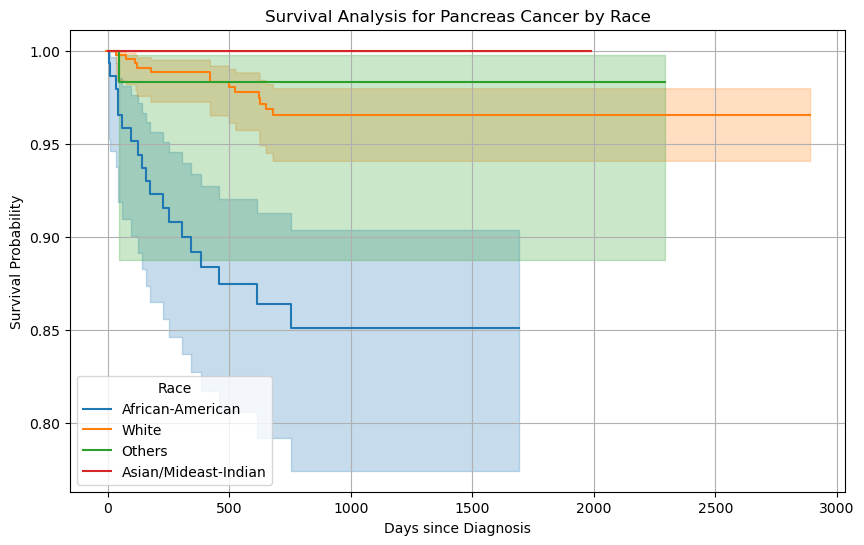

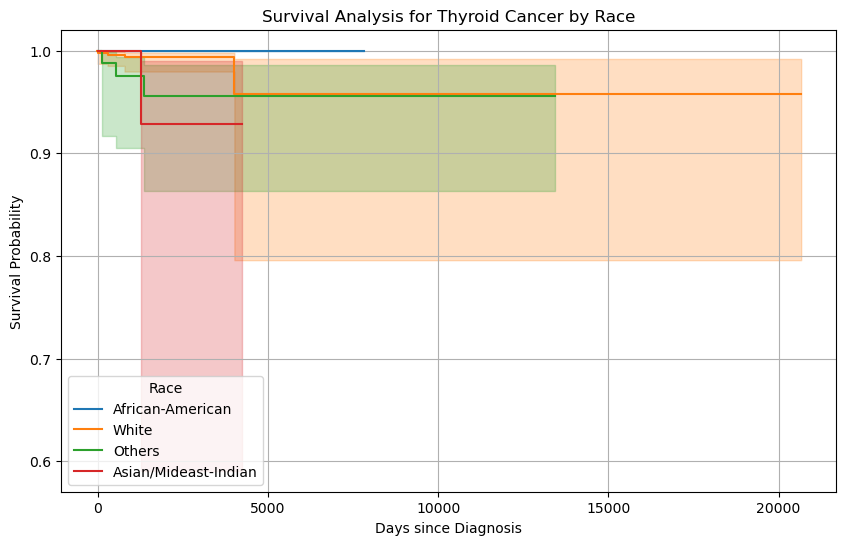

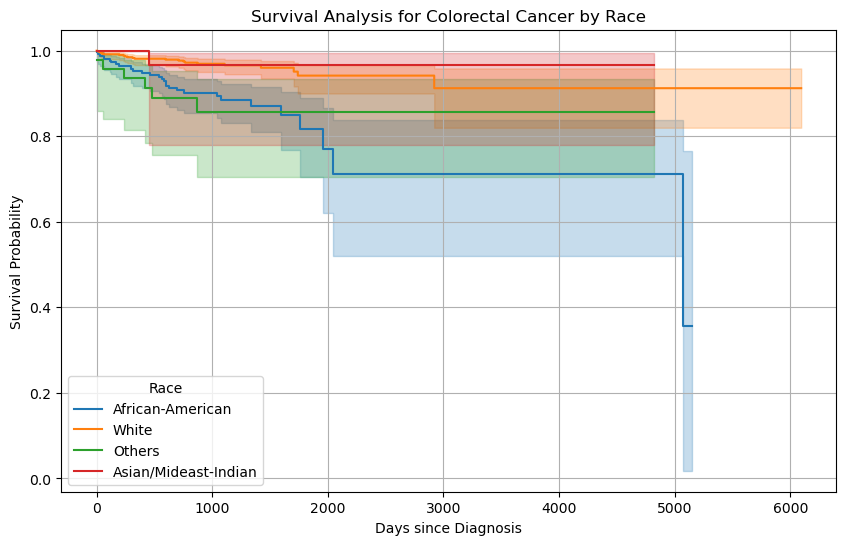

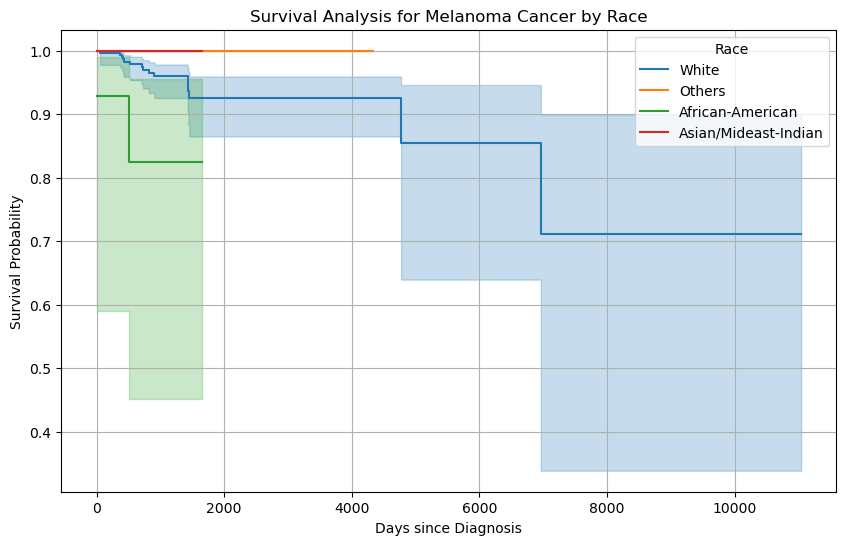

In [33]:
for cancer in cancers:
    # Filter data for the specific cancer type
    data_cancer = final_data[final_data['cancer_type'] == cancer]
    
    # Get unique races in the dataset
    races = data_cancer['race'].unique()
    
    # Create a new figure for the cancer type
    plt.figure(figsize=(10, 6))
    
    # Loop over each race
    for race in races:
        # Filter data for the specific race
        data_race = data_cancer[data_cancer['race'] == race]
        
        # Check if there is enough data to plot
        if data_race.empty:
            continue
        
        # Fit the Kaplan-Meier model for the specific cancer type and race
        kmf.fit(durations=data_race['duration'],
                event_observed=data_race['event_observed'],
                label=f'{race}')
        
        # Plot the survival function
        kmf.plot_survival_function()

    # Add title and labels
    plt.title(f'Survival Analysis for {cancer.capitalize()} Cancer by Race')
    plt.xlabel('Days since Diagnosis')
    plt.ylabel('Survival Probability')
    plt.legend(title='Race')
    plt.grid(True)
        
    # Show plot
    plt.show()


## Survival Analysis by Age Groups

In [34]:
# Define the age groups based on deciles
age_groups = [(10, 20), (20, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 80), (80, 90), (90, 100)]


In [35]:
# Function to categorize age
def categorize_age(age):
    for lower, upper in age_groups:
        if lower < age <= upper:
            return f"{lower+1}-{upper}"
    return "Out of range"

In [36]:
# Apply the function to create a new 'age_group' column
final_data['age_group'] = final_data['age_at_diagnosis'].apply(categorize_age)
final_data

,death_date_off,sex,race,diagnosis_date,age_at_diagnosis,censored,duration,event_observed,cancer_type,age_group
0,NaT,Male,African-American,2013-09-01,54.0,True,1089.0,False,lung,51-60
1,2016-04-20,Male,African-American,2016-04-02,60.0,False,18.0,True,lung,51-60
2,2015-05-25,Female,African-American,2015-04-11,69.0,False,44.0,True,lung,61-70
3,NaT,Male,African-American,2012-11-29,55.0,True,1365.0,False,lung,51-60
4,NaT,Male,African-American,2013-05-21,73.0,True,1192.0,False,lung,71-80
...,...,...,...,...,...,...,...,...,...,...
4177,NaT,Female,White,2010-08-01,46.0,True,2216.0,False,melanoma,41-50
4178,NaT,Female,White,2015-10-25,35.0,True,305.0,False,melanoma,31-40
4179,NaT,Male,White,2013-11-09,64.0,True,1020.0,False,melanoma,61-70
4180,NaT,Female,White,2013-01-06,57.0,True,1327.0,False,melanoma,51-60


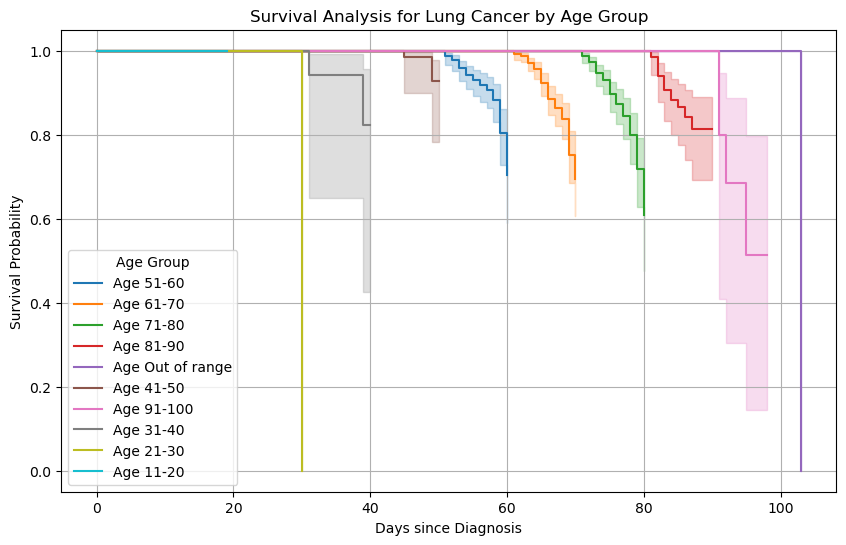

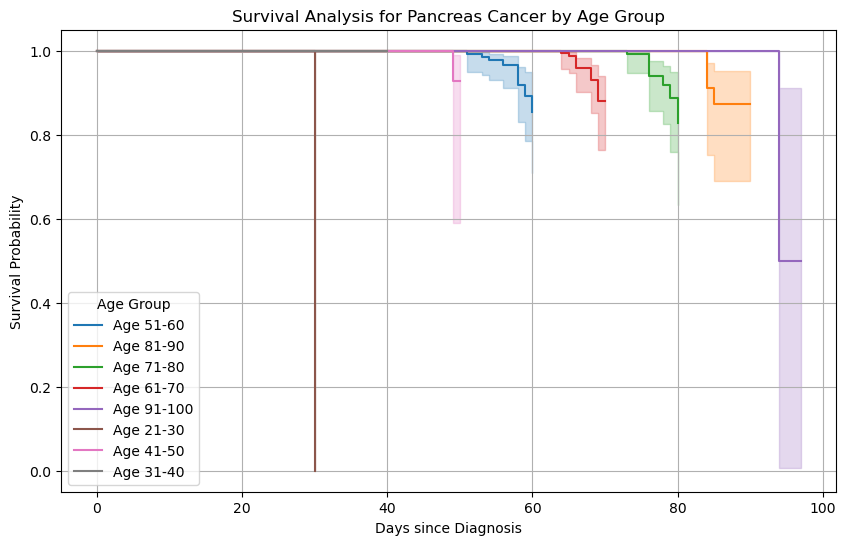

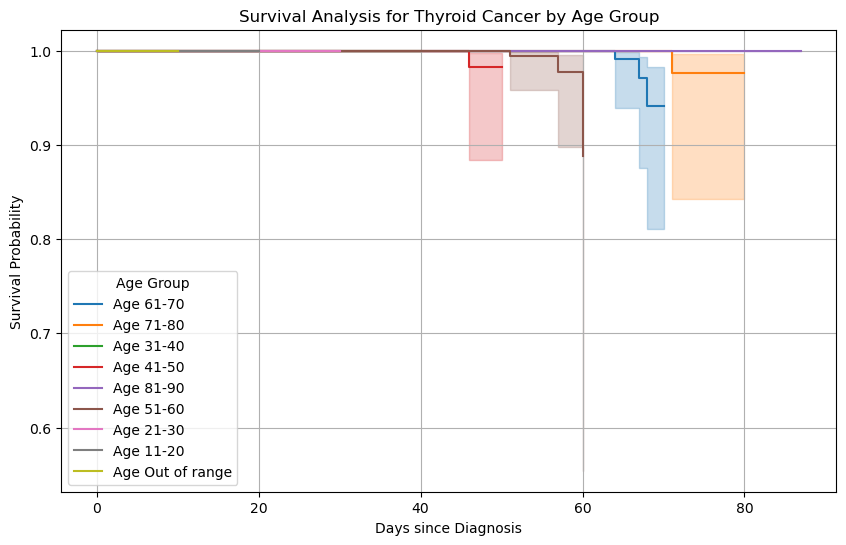

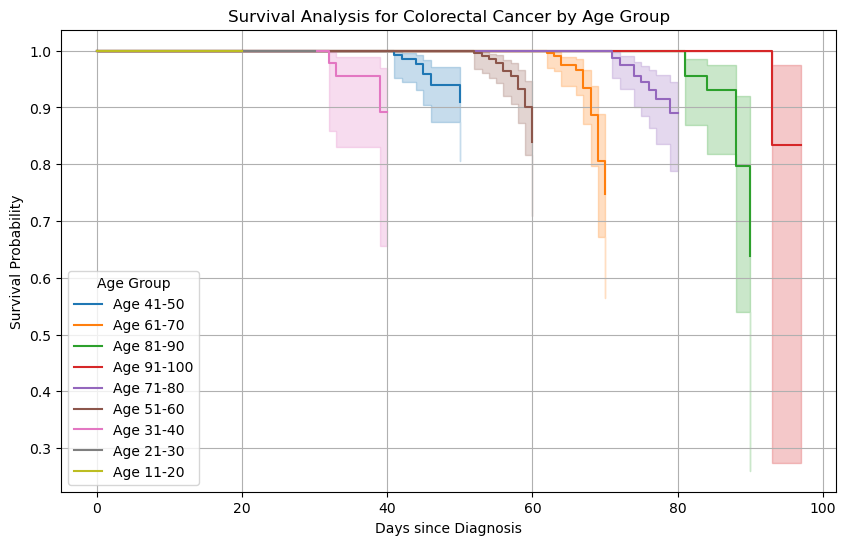

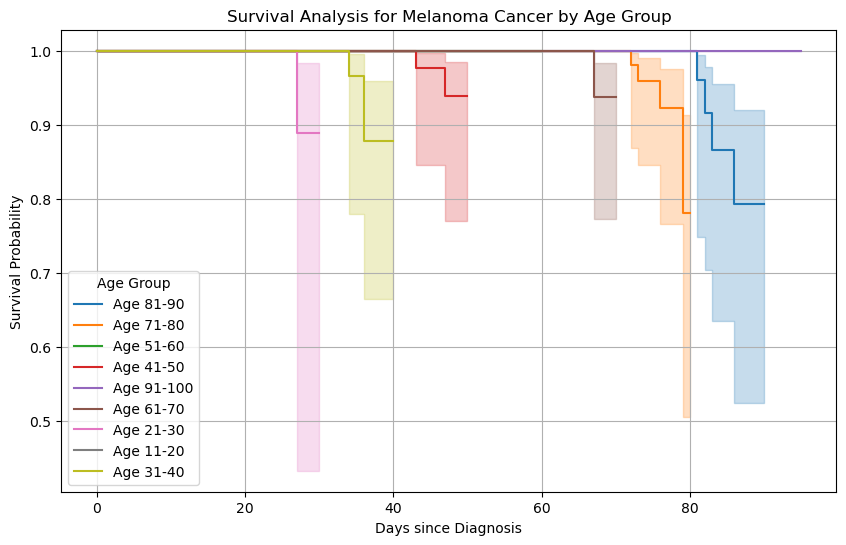

The age group with the lowest survival after 400 days is 71-80 with a survival probability of 0.78


In [37]:
survival_rates_400_days = {}

for cancer in cancers:
    # Filter data for the specific cancer type
    data_cancer = final_data[final_data['cancer_type'] == cancer]
    
    # Get unique age groups in the dataset
    age_group_labels = data_cancer['age_group'].unique()
    
    # Create a new figure for the cancer type
    plt.figure(figsize=(10, 6))
    
    # Loop over each age group
    for age_group_label in age_group_labels:
        # Filter data for the specific age group
        data_age_group = data_cancer[data_cancer['age_group'] == age_group_label]
        
        # Check if there is enough data to plot
        if data_age_group.empty:
            continue
        
        # Fit the Kaplan-Meier model for the specific cancer type and age group
        kmf.fit(durations=data_age_group['age_at_diagnosis'],
                event_observed=data_age_group['event_observed'],
                label=f'Age {age_group_label}')
        
        # Plot the survival function
        kmf.plot_survival_function()

        survival_probability_at_400_days = kmf.predict(400)

        survival_rates_400_days[age_group_label] = survival_probability_at_400_days

    # Add title and labels
    plt.title(f'Survival Analysis for {cancer.capitalize()} Cancer by Age Group')
    plt.xlabel('Days since Diagnosis')
    plt.ylabel('Survival Probability')
    plt.legend(title='Age Group')
    plt.grid(True)
        
    # Show plot
    plt.show()

    # After the loop, find the age group with the lowest survival probability at 400 days
lowest_survival_age_group = min(survival_rates_400_days, key=survival_rates_400_days.get)
lowest_survival_probability = survival_rates_400_days[lowest_survival_age_group]

print(f"The age group with the lowest survival after 400 days is {lowest_survival_age_group} with a survival probability of {lowest_survival_probability:.2f}")


# Save

In [38]:
final_data.to_csv('/Users/kajalshukla/Desktop/DS in Healthcare/Assignment_2/cancer_analysis_data.csv', index=False)

# Analysis

In [3]:
cancer_data = pd.read_csv("/Users/kajalshukla/Desktop/DS in Healthcare/Assignment_2/cancer_analysis_data.csv")


In [4]:
cancer_data

,death_date_off,sex,race,diagnosis_date,age_at_diagnosis,censored,duration,event_observed,cancer_type,age_group
0,NaN,Male,African-American,2013-09-01,54.0,True,1089.0,False,lung,51-60
1,2016-04-20,Male,African-American,2016-04-02,60.0,False,18.0,True,lung,51-60
2,2015-05-25,Female,African-American,2015-04-11,69.0,False,44.0,True,lung,61-70
3,NaN,Male,African-American,2012-11-29,55.0,True,1365.0,False,lung,51-60
4,NaN,Male,African-American,2013-05-21,73.0,True,1192.0,False,lung,71-80
...,...,...,...,...,...,...,...,...,...,...
4177,NaN,Female,White,2010-08-01,46.0,True,2216.0,False,melanoma,41-50
4178,NaN,Female,White,2015-10-25,35.0,True,305.0,False,melanoma,31-40
4179,NaN,Male,White,2013-11-09,64.0,True,1020.0,False,melanoma,61-70
4180,NaN,Female,White,2013-01-06,57.0,True,1327.0,False,melanoma,51-60


In [6]:
cancer_types = cancer_data["cancer_type"].unique()

# Dictionary to hold the fitted models for each cancer type
kmf_models = {}

for cancer in cancer_types:
    kmf_models[cancer] = KaplanMeierFitter()
    kmf_models[cancer].fit(
        durations=cancer_data.loc[cancer_data["cancer_type"] == cancer, "duration"],
        event_observed=cancer_data.loc[cancer_data["cancer_type"] == cancer, "event_observed"]
    )

In [7]:
# Now, let's find the cancer type with the highest and lowest survival probabilities
survival_at_last_timepoint = {
    cancer: model.survival_function_.iloc[-1, 0]
    for cancer, model in kmf_models.items()
}

In [9]:
survival_at_last_timepoint

{'lung': 0.0,
 'pancreas': 0.942965351786041,
 'thyroid': 0.9550128532032433,
 'colorectal': 0.7442974355784815,
 'melanoma': 0.7118695859093133}

In [14]:
# Identify the cancer type with the highest survival
highest_survival_cancer = max(survival_at_last_timepoint, key=survival_at_last_timepoint.get)
# And the one with the lowest survival
lowest_survival_cancer = min(survival_at_last_timepoint, key=survival_at_last_timepoint.get)

print(highest_survival_cancer)
print(lowest_survival_cancer)

thyroid
lung


In [15]:
female_colorectal_cancer = cancer_data[(cancer_data['sex'] == 'Female') & (cancer_data['cancer_type'] == 'colorectal')]


In [16]:
# Fit the Kaplan-Meier model on the filtered data
fem_col = kmf.fit(durations=female_colorectal_cancer['duration'], 
        event_observed=female_colorectal_cancer['event_observed'])

In [17]:
# Predict the survival probability at 1000 days
survival_probability_at_1000_days = fem_col.predict(1000)
survival_probability_at_1000_days

0.9484362597817692

In [18]:
male_lung_cancer = cancer_data[(cancer_data['sex'] == 'Male') & (cancer_data['cancer_type'] == 'lung')]

# Fit the Kaplan-Meier model on the filtered data
male_lung = kmf.fit(durations=male_lung_cancer['duration'], 
        event_observed=male_lung_cancer['event_observed'])

# Predict the survival probability at 1000 days
survival_probability_at_300_days = male_lung.predict(300)
survival_probability_at_300_days

0.9150044317437944

In [19]:
female_melanoma_cancer = cancer_data[(cancer_data['sex'] == 'Female') & (cancer_data['cancer_type'] == 'melanoma')]

# Fit the Kaplan-Meier model on the filtered data
female_melanoma = kmf.fit(durations=female_melanoma_cancer['duration'], 
        event_observed=female_melanoma_cancer['event_observed'])

# Predict the survival probability at 1200 days
survival_probability_at_1200_days = female_melanoma.predict(1200)
survival_probability_at_1200_days


0.9587861344911673

In [20]:
male_thyroid_cancer = cancer_data[(cancer_data['sex'] == 'Male') & (cancer_data['cancer_type'] == 'thyroid')]

male_thyroid = kmf.fit(durations=male_thyroid_cancer['duration'], 
        event_observed=male_thyroid_cancer['event_observed'])

# Predict the survival probability at 1200 days
survival_probability_at_1500_days = male_thyroid.predict(1500)
survival_probability_at_1500_days

0.9723197357959752

In [21]:
male_pancreatic_cancer = cancer_data[(cancer_data['sex'] == 'Male') & (cancer_data['cancer_type'] == 'pancreas')]

male_pancreatic = kmf.fit(durations=male_pancreatic_cancer['duration'], 
        event_observed=male_pancreatic_cancer['event_observed'])

# Predict the survival probability at 1200 days
survival_probability_at_2200_days = male_pancreatic.predict(2200)
survival_probability_at_2200_days

0.9527730420915841

In [22]:
# Filter your data for African-Americans with colorectal cancer
aa_colorectal_cancer = cancer_data[(cancer_data['race'] == 'African-American') & (cancer_data['cancer_type'] == 'colorectal')]

aa_colorectal = kmf.fit(durations=aa_colorectal_cancer['duration'], 
        event_observed=aa_colorectal_cancer['event_observed'])

survival_probability_at_2000_days = aa_colorectal.predict(2000)
survival_probability_at_2000_days


0.7707008809959308

In [23]:
# Filter your data for African-Americans with colorectal cancer
white_lung_cancer = cancer_data[(cancer_data['race'] == 'White') & (cancer_data['cancer_type'] == 'lung')]

white_colorectal = kmf.fit(durations=white_lung_cancer['duration'], 
        event_observed=white_lung_cancer['event_observed'])

survival_probability_at_1000_days = white_colorectal.predict(1000)
survival_probability_at_1000_days

0.9093202754096159

In [25]:
duration_days = 2 * 365
duration_days

730

In [26]:
aa_melanoma_cancer = cancer_data[(cancer_data['race'] == 'African-American') & (cancer_data['cancer_type'] == 'melanoma')]

aa_melanoma = kmf.fit(durations=aa_melanoma_cancer['duration'], 
        event_observed=aa_melanoma_cancer['event_observed'])

# Predict the survival probability at 730 days (2 years)
survival_probability_at_730_days = aa_melanoma.predict(730)
survival_probability_at_730_days

0.8253968253968252

In [27]:
duration_days = 3 * 365
duration_days

1095

In [28]:
white_pancreatic_cancer = cancer_data[(cancer_data['race'] == 'White') & (cancer_data['cancer_type'] == 'pancreas')]

white_pancreatic = kmf.fit(durations=white_pancreatic_cancer['duration'], 
        event_observed=white_pancreatic_cancer['event_observed'])

# Predict the survival probability at 1095 days (3 years)
survival_probability_at_1095_days = white_pancreatic.predict(1095)
survival_probability_at_1095_days

0.9653827525410603

In [29]:
asians_thyroid_cancer = cancer_data[(cancer_data['race'] == 'Asian/Mideast-Indian') & (cancer_data['cancer_type'] == 'thyroid')]

asians_thyroid = kmf.fit(durations=asians_thyroid_cancer['duration'], 
        event_observed=asians_thyroid_cancer['event_observed'])

# Predict the survival probability at 1500 days 
survival_probability_at_1500_days = asians_thyroid.predict(1500)
survival_probability_at_1500_days

0.9285714285714287

In [68]:
# Assuming 'final_data' is your DataFrame and 'kmf' is your KaplanMeierFitter instance

# Filter data for colorectal cancer
colorectal_data = cancer_data[cancer_data['cancer_type'] == 'colorectal']

# Get unique age groups in the dataset
age_groups = colorectal_data['age_group'].unique()

# Dictionary to store the final survival probability for each age group
final_survival_probabilities = {}

for age_group in age_groups:
    # Filter data for the specific age group
    group_data = colorectal_data[colorectal_data['age_group'] == age_group]
    
    # Fit Kaplan-Meier model for this group
    kmf.fit(durations=group_data['duration'], event_observed=group_data['event_observed'])
    
    # Get the survival function
    survival_function = kmf.survival_function_
    
    # Get the last survival probability (at the end of the study)
    final_survival_probability = survival_function.iloc[-1, 0]
    
    # Store the final survival probability for the age group
    final_survival_probabilities[age_group] = final_survival_probability

# Determine the age group with the lowest final survival probability
# lowest_survival_age_group = min(final_survival_probabilities, key=final_survival_probabilities.get)

# print(f"The age group with the lowest survival for colorectal cancer at the end of the study is: {lowest_survival_age_group}")
# print(f"Survival probability: {final_survival_probabilities[lowest_survival_age_group]}")
final_survival_probabilities


{'41-50': 0.9132830053935169,
 '61-70': 0.8575205278147496,
 '81-90': 0.8764883053705191,
 '91-100': 0.8750000000000001,
 '71-80': 0.9311203565912635,
 '51-60': 0.0,
 '31-40': 0.8078351908139144,
 '21-30': 1.0,
 '11-20': 1.0}

In [69]:
# Assuming 'final_data' is your DataFrame and 'kmf' is your KaplanMeierFitter instance

# Filter data for colorectal cancer
lung_data = cancer_data[cancer_data['cancer_type'] == 'lung']

# Get unique age groups in the dataset
age_groups = lung_data['age_group'].unique()

# Dictionary to store the final survival probability for each age group
final_survival_probabilities = {}

for age_group in age_groups:
    # Filter data for the specific age group
    group_data = lung_data[lung_data['age_group'] == age_group]
    
    # Fit Kaplan-Meier model for this group
    kmf.fit(durations=group_data['duration'], event_observed=group_data['event_observed'])
    
    # Get the survival function
    survival_function = kmf.survival_function_
    
    # Get the last survival probability (at the end of the study)
    final_survival_probability = survival_function.iloc[-1, 0]
    
    # Store the final survival probability for the age group
    final_survival_probabilities[age_group] = final_survival_probability

# Determine the age group with the lowest final survival probability
# highest_survival_age_group = max(final_survival_probabilities, key=final_survival_probabilities.get)

# print(f"The age group with the highest survival for lung cancer at the end of the study is: {highest_survival_age_group}")
# print(f"Survival probability: {final_survival_probabilities[highest_survival_age_group]}")

final_survival_probabilities


{'51-60': 0.0,
 '61-70': 0.8154383602080637,
 '71-80': 0.793821888098276,
 '81-90': 0.7786158604425524,
 'Out of range': 0.5,
 '41-50': 0.8670465337132008,
 '91-100': 0.5599999999999998,
 '31-40': 0.7111111111111109,
 '21-30': 0.6666666666666666,
 '11-20': 1.0}

In [32]:
duration_days = 5 * 365
duration_days

1825

In [33]:
age_melanoma_cancer = cancer_data[(cancer_data['cancer_type'] == 'melanoma') & (cancer_data['age_group'] == '61-70')]

age_melanoma = kmf.fit(durations=age_melanoma_cancer['duration'], event_observed=age_melanoma_cancer['event_observed'])

survival_probability_5_years = age_melanoma.predict(1825)
survival_probability_5_years

0.9729128014842297

In [34]:
age_pancreatic_cancer = cancer_data[(cancer_data['cancer_type'] == 'pancreas') & (cancer_data['age_group'] == '21-30')]

age_pancreatic = kmf.fit(durations=age_pancreatic_cancer['duration'], event_observed=age_pancreatic_cancer['event_observed'])

survival_probability_1_years = age_pancreatic.predict(365)
survival_probability_1_years

0.7500000000000001

In [35]:
age_thyroid_cancer = cancer_data[(cancer_data['cancer_type'] == 'thyroid') & (cancer_data['age_group'] == '51-60')]

age_thyroid = kmf.fit(durations=age_thyroid_cancer['duration'], event_observed=age_thyroid_cancer['event_observed'])

survival_probability_2200_years = age_thyroid.predict(2200)
survival_probability_2200_years

0.9590643274853804

In [36]:
race_groups = cancer_data['race'].unique()
survival_rates = {}

for race in race_groups:
    # Filter data for the specific race
    data_race = cancer_data[cancer_data['race'] == race]
    
    # Check if there is enough data to proceed
    if not data_race.empty:
        # Fit the Kaplan-Meier model for this race
        kmf.fit(durations=data_race['duration'], event_observed=data_race['event_observed'])
        
        # Calculate survival rate at 2500 days
        survival_rate_at_2500_days = kmf.predict(2500)
        survival_rates[race] = survival_rate_at_2500_days
        
highest_survival_race = max(survival_rates, key=survival_rates.get)
highest_survival_rate = survival_rates[highest_survival_race]

print(highest_survival_race)
print(highest_survival_rate)

White
0.9263470457670738


In [37]:
# Filter out patients who have been diagnosed for less than 400 days
cancer_data['survived_400_days'] = (cancer_data['duration'] >= 400) & (~cancer_data['event_observed'])


In [39]:
# Group by age group and calculate the survival rate for each group at 400 days
survival_rates_400_days = cancer_data.groupby('age_group')['survived_400_days'].mean()
survival_rates_400_days

age_group
11-20           0.888889
21-30           0.891892
31-40           0.885593
41-50           0.884444
51-60           0.825758
61-70           0.818257
71-80           0.770302
81-90           0.756667
91-100          0.700000
Out of range    0.750000
Name: survived_400_days, dtype: float64

In [40]:
# Identify the age group with the lowest survival rate after 400 days
lowest_survival_age_group = survival_rates_400_days.idxmin()
lowest_survival_rate = survival_rates_400_days.min()

print(f"The age group with the lowest survival after 400 days is {lowest_survival_age_group} with a survival rate of {lowest_survival_rate:.2%}.")

The age group with the lowest survival after 400 days is 91-100 with a survival rate of 70.00%.
